In [1]:
import pandas as pd
import numpy as np
import pdb 
from datetime import datetime, timedelta
from dis import dis
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv("prepped_data.csv")

In [2]:
data_per_image = data.groupby(['origin']).mean()
data_per_image = data_per_image.sort_values(by=["score"])

# For malginant and benign images each
images = np.unique(data['origin'])

image_class = []
for i in images:
    tmp_label = data.loc[data['origin'] == i]['current_correct_answer'].iloc[0]
    image_class.append(tmp_label)
    
sort_by_image_id = data_per_image.sort_index()[:len(images)] #sort images by image name
sort_by_image_id['class'] = image_class

# retrieve melanoma and nevus images
melanoma = sort_by_image_id.loc[sort_by_image_id['class']=="['melanoma']"]
nevus = sort_by_image_id.loc[sort_by_image_id['class']=="['nevus']"]

#sort nevus descending and turn negative, melanoma ascending
melanoma.sort_values(by=["score"], inplace = True)
nevus.sort_values(by=["score"], ascending = False, inplace = True)
nevus  = nevus*-1
combined_images = nevus.append(melanoma)

In [3]:
# Malignancy plot
x = combined_images.index
y = combined_images['score']
plt.figure(figsize=(18, 5))
plt.scatter(x,y,s=0.5)
plt.axhline(y=0,linewidth=0.5, color='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('malignancy')
plt.xlabel('ordered images')
plt.show()

KeyboardInterrupt: 

In [4]:
# number of malignant images: 1110, min times an image was shown: 95, max: 380:
data['origin'][data['current_correct_answer']== "['melanoma']"].value_counts() 

# number of benign images: 6688, min times an image was shown: 34, max: 106:
data['origin'][data['current_correct_answer']== "['nevus']"].value_counts() 

ISIC_0028136.jpg    106
ISIC_0028675.jpg    102
ISIC_0024894.jpg    102
ISIC_0028800.jpg    101
ISIC_0024784.jpg    101
ISIC_0025653.jpg    101
ISIC_0032801.jpg    101
ISIC_0030269.jpg    101
ISIC_0026764.jpg    100
ISIC_0031014.jpg    100
ISIC_0031316.jpg    100
ISIC_0025562.jpg    100
ISIC_0032912.jpg    100
ISIC_0032880.jpg    100
ISIC_0025820.jpg    100
ISIC_0030837.jpg    100
ISIC_0025462.jpg    100
ISIC_0034271.jpg    100
ISIC_0029904.jpg    100
ISIC_0033669.jpg    100
ISIC_0026926.jpg    100
ISIC_0024895.jpg    100
ISIC_0026445.jpg    100
ISIC_0026692.jpg    100
ISIC_0026822.jpg    100
ISIC_0031462.jpg    100
ISIC_0033769.jpg    100
ISIC_0034152.jpg    100
ISIC_0030797.jpg    100
ISIC_0026999.jpg    100
                   ... 
ISIC_0028874.jpg     38
ISIC_0026533.jpg     38
ISIC_0027902.jpg     38
ISIC_0030483.jpg     38
ISIC_0025993.jpg     38
ISIC_0033091.jpg     38
ISIC_0032492.jpg     38
ISIC_0028446.jpg     38
ISIC_0032047.jpg     38
ISIC_0034286.jpg     38
ISIC_0026863.jpg

In [5]:
malignancy = combined_images['score']
data['malignancy'] = np.nan

for i,n in enumerate(malignancy.index):
    data['malignancy'][data['origin']==n] = malignancy.values[i]   

In [54]:
similarity = data['malignancy'].shift(periods = 1) - data['malignancy'] #previous - current malignancy 
data['similarity_to_previous'] = similarity
data['similarity_bins'] = pd.cut(x=similarity, bins=np.arange(-200,210,10))
data_per_bin = data.groupby(['similarity_bins']).mean()

In [55]:
print(data[(data['similarity_to_previous']<50) & (data['similarity_to_previous']>-50)]['1back_accuracy'].mean())
print(data[(data['similarity_to_previous']<50) & (data['similarity_to_previous']>-50)]['2back_accuracy'].mean())
print(data[(data['similarity_to_previous']<50) & (data['similarity_to_previous']>-50)]['3back_accuracy'].mean())

0.7957660760051135
0.5058810196217769
0.5062550617223354


In [56]:
data[(data['malignancy']<50) & data['malignancy']>-50]['1back_accuracy'].mean()

0.5034350558511203

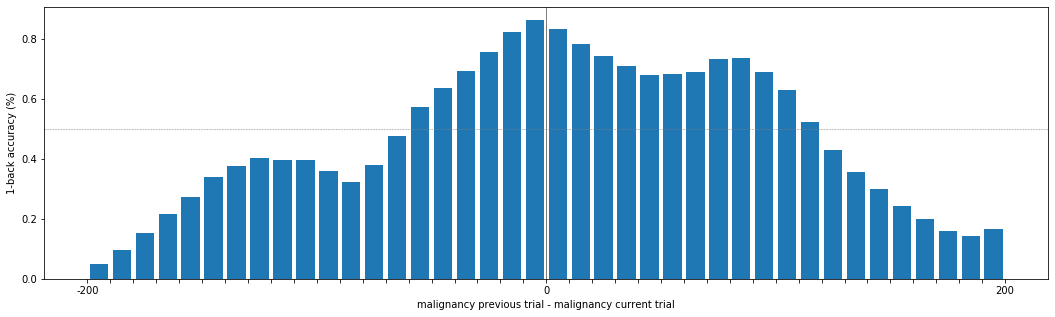

In [61]:
# PLOT 1: Similarity Barplot over all trials
y = data_per_bin['1back_accuracy']
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('1-back accuracy (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--') #

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: above 0.5 SD is apparent

### 1-Back analysis before Merging two sides

<Figure size 432x288 with 0 Axes>

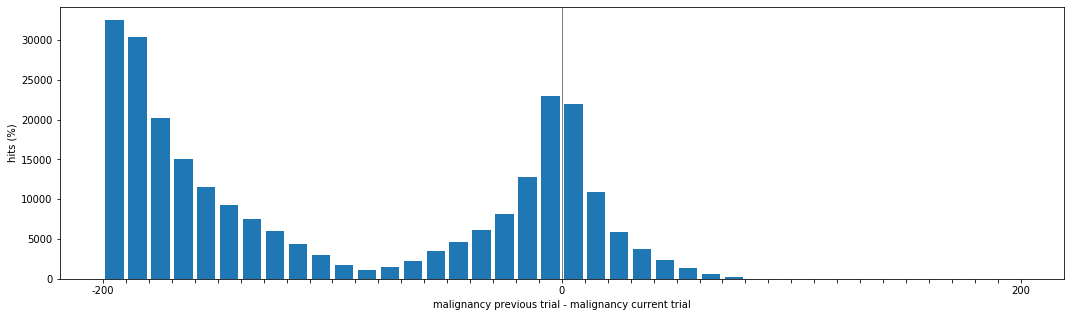

<Figure size 432x288 with 0 Axes>

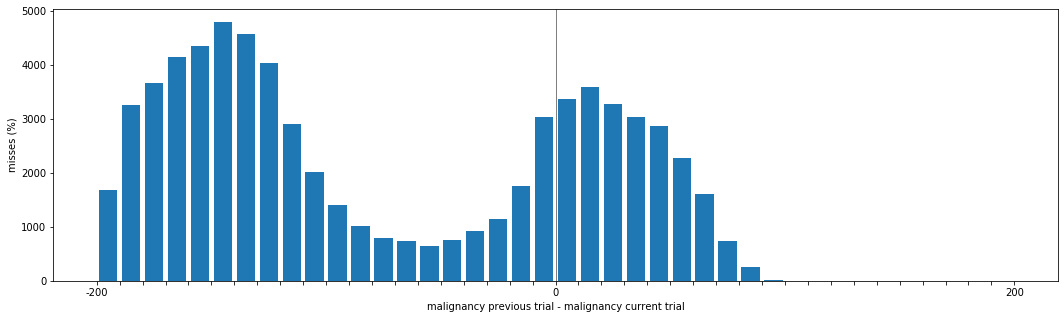

<Figure size 432x288 with 0 Axes>

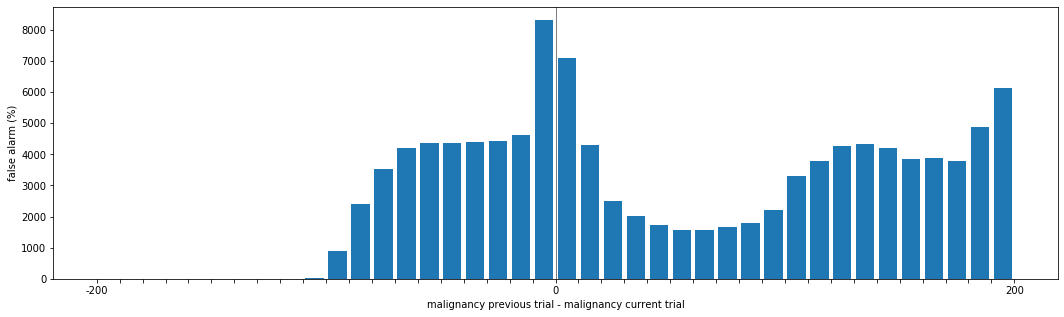

<Figure size 432x288 with 0 Axes>

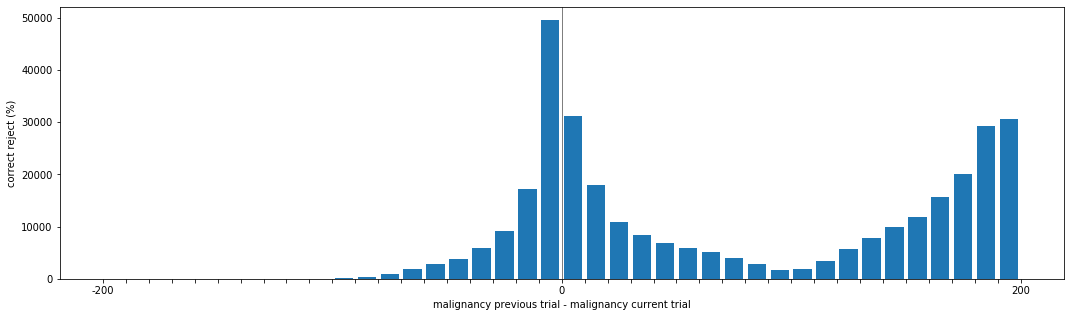

<Figure size 432x288 with 0 Axes>

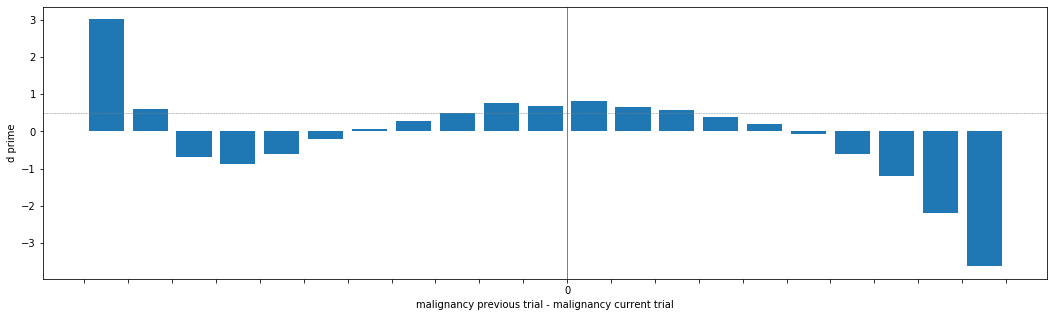

<Figure size 432x288 with 0 Axes>

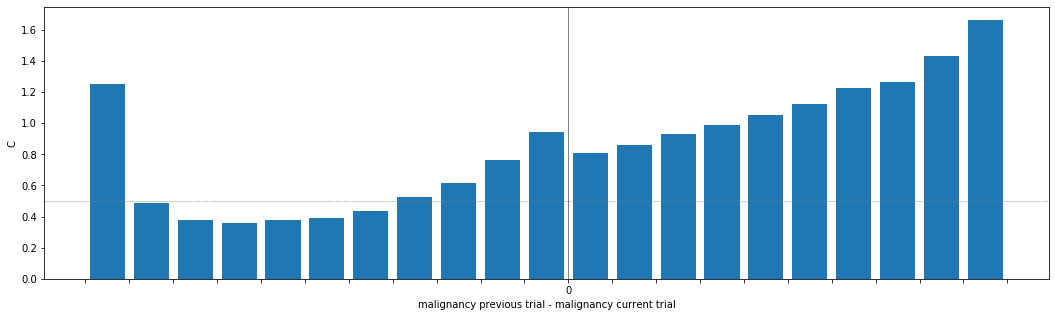

<Figure size 432x288 with 0 Axes>

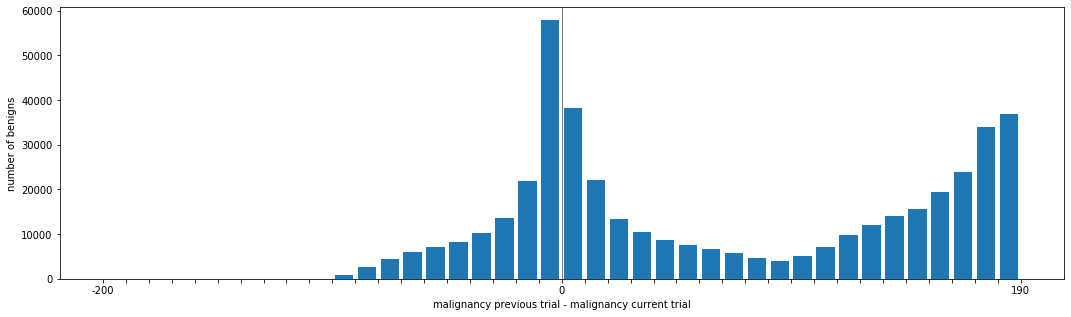

<Figure size 432x288 with 0 Axes>

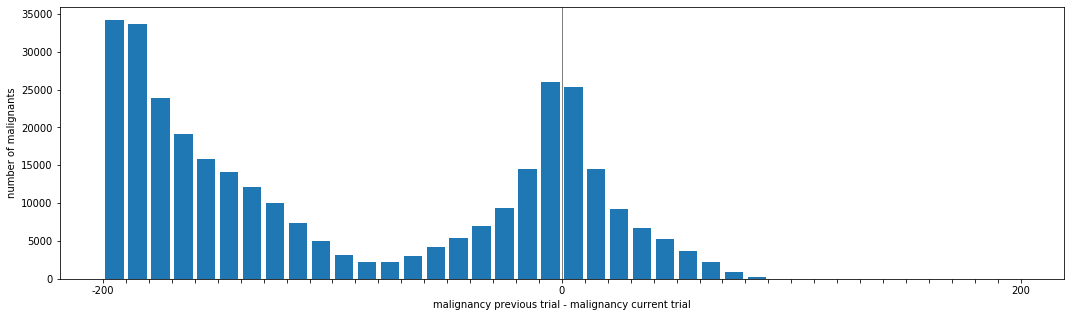

In [60]:
import scipy.stats as stats

hit_1back = []
miss_1back = []
FA_1back = []
CR_1back = []
lengths_1back = []
num_benign_1back = []
num_malignant_1back = []
# balance_rate = []
for start in np.arange(-200,210,10):
    data_temp = data[data['similarity_bins'] == pd.Interval(start, start + 10, closed='right')]
    lengths_1back.append(data_temp.shape[0])
#     hit_1back.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum() / lenth)
#     FA_1back.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum() / lenth)
#     miss_1back.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum() / lenth)
#     CR_1back.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['nevus']")).sum() / lenth)
    hit_1back.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum())
    FA_1back.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum())
    miss_1back.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum())
    CR_1back.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['nevus']")).sum())

    num_benign_1back.append(FA_1back[-1] + CR_1back[-1])
    num_malignant_1back.append(hit_1back[-1] + miss_1back[-1])
#     balance_rate.append(num_malignant[-1]/num_benign[-1])
    
# PLOT 1: hits
plt.figure()
y = hit_1back[:-1]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: miss
plt.figure()
y = miss_1back[:-1]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 3: false alarm
plt.figure()
y = FA_1back[:-1]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 4: correct reject
plt.figure()
y = CR_1back[:-1]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 5: d'
plt.figure()
y_1back_d = [stats.norm.ppf(a/c) - stats.norm.ppf(b/c) for (a,b,c) in zip(hit_1back[:-1], FA_1back[:-1], lengths_1back[:-1])]
# y_1back_d = [0 if a != a else a for a in y_1back_d]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_d)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y_1back_c = [-(stats.norm.ppf(a/c) + stats.norm.ppf(b/c))/2 for (a,b,c) in zip(hit_1back[:-1], FA_1back[:-1], lengths_1back[:-1])]
# y_1back_c = [0 if a != a else a for a in y_1back_c]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_c)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 7: benign samples
plt.figure()
y = num_benign_1back[:-1]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 190
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('number of benigns')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 8: malignant samples
plt.figure()
y = num_malignant_1back[:-1]
x = data_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('number of malignants')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

### 1-Back analysis after Merging two sides

/Users/peterren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/peterren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

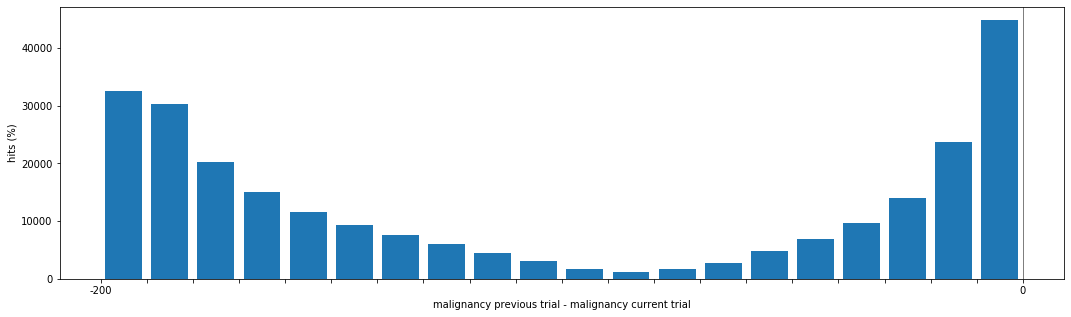

<Figure size 432x288 with 0 Axes>

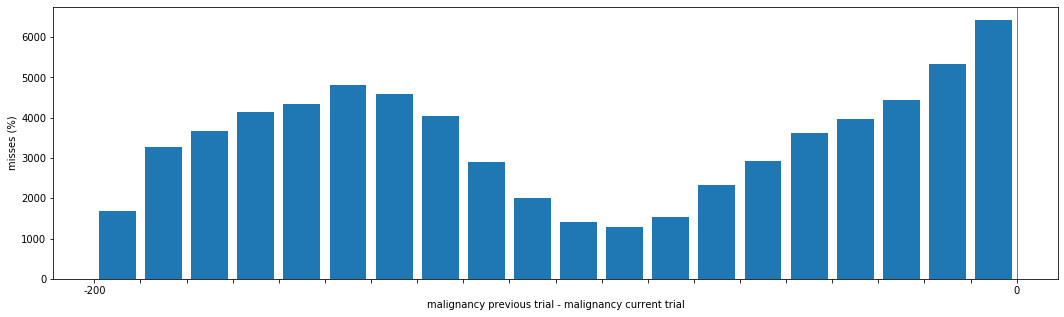

<Figure size 432x288 with 0 Axes>

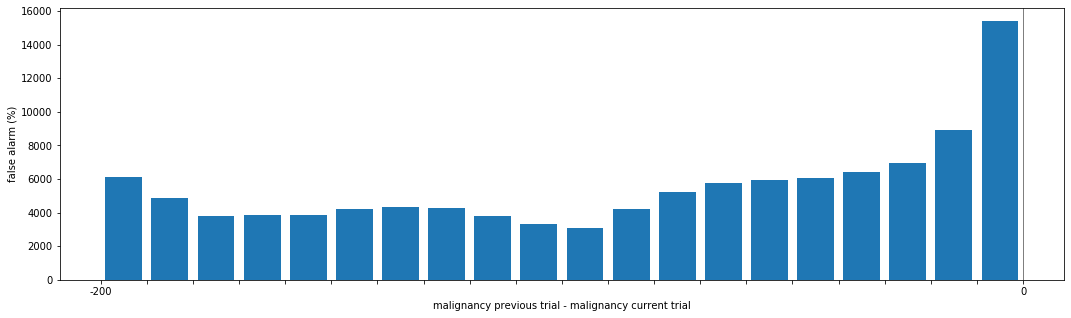

<Figure size 432x288 with 0 Axes>

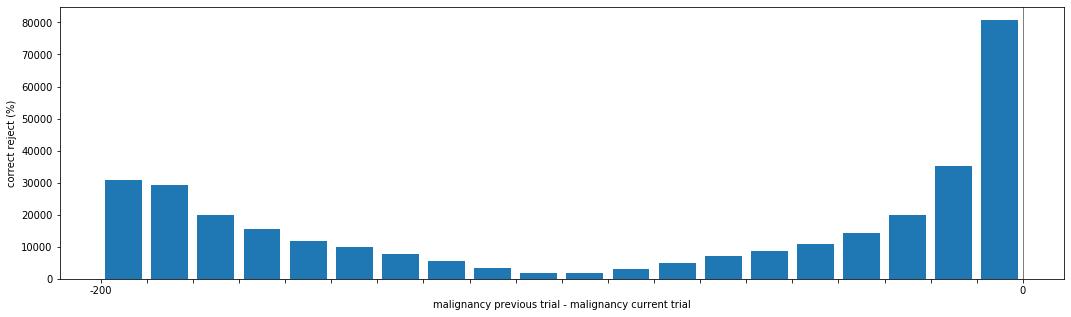

<Figure size 432x288 with 0 Axes>

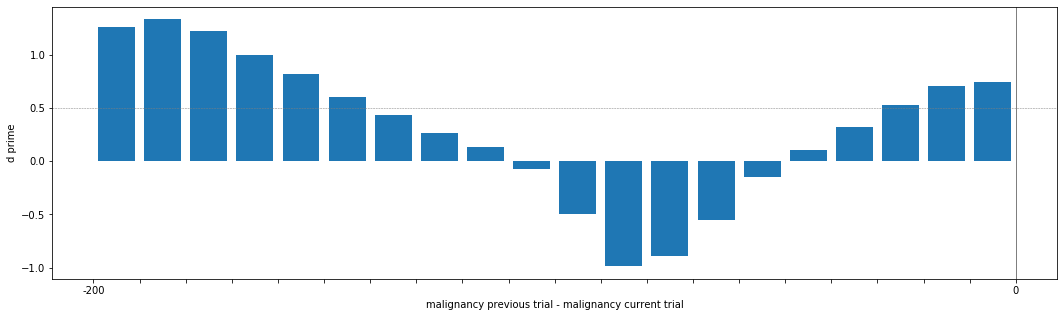

<Figure size 432x288 with 0 Axes>

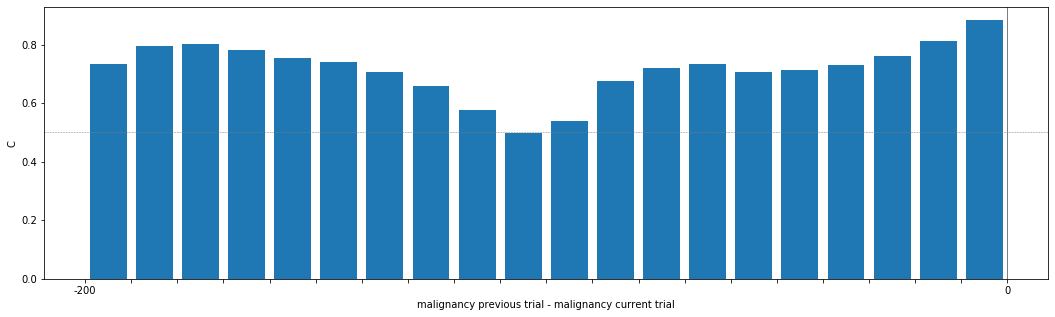

<Figure size 432x288 with 0 Axes>

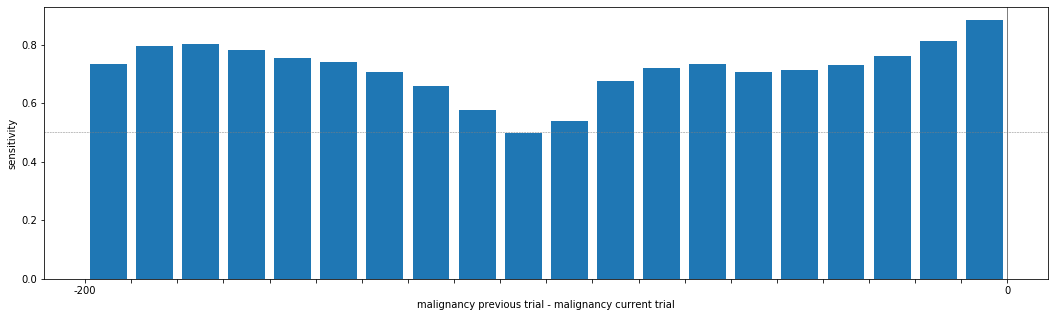

<Figure size 432x288 with 0 Axes>

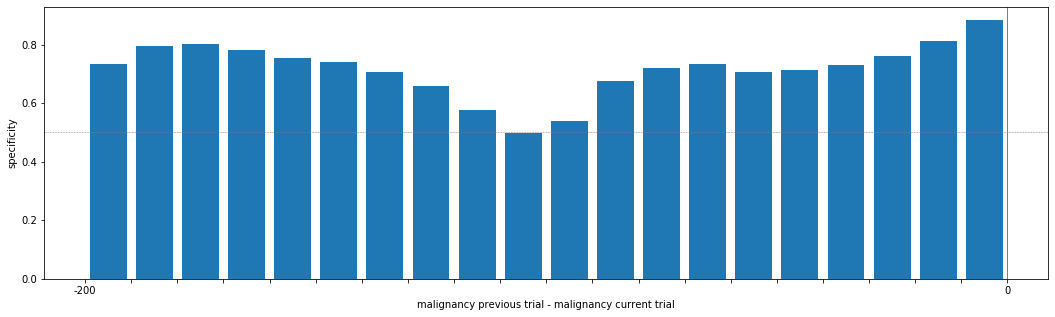

<Figure size 432x288 with 0 Axes>

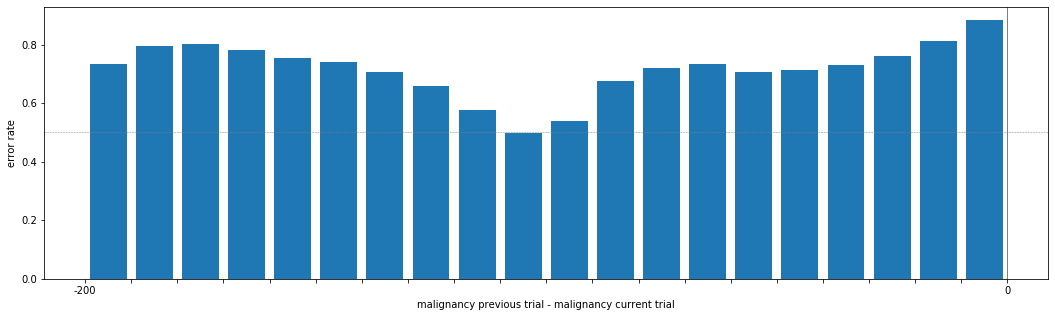

<Figure size 432x288 with 0 Axes>

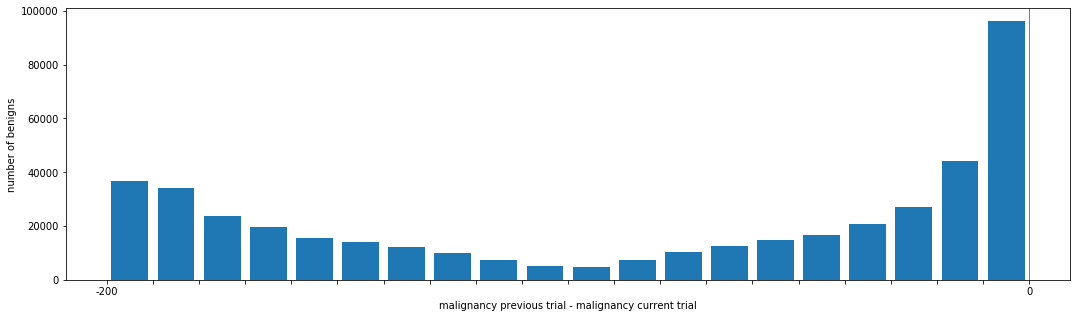

<Figure size 432x288 with 0 Axes>

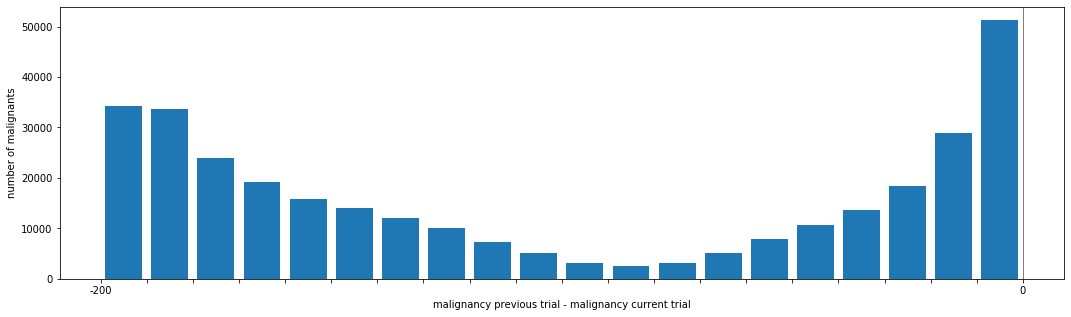

In [80]:
hit_1back_merge = np.zeros(20,)
miss_1back_merge = np.zeros(20,)
FA_1back_merge = np.zeros(20,)
CR_1back_merge = np.zeros(20,)
lengths_1back_merge = np.zeros(20,)
num_benign_1back_merge = np.zeros(20,)
num_malignant_1back_merge = np.zeros(20,)
sensitivity_1back_merge = np.zeros(20,)
specificity_1back_merge = np.zeros(20,)
error_rate_1back_merge = np.zeros(20,)

for i in range(20):
    hit_1back_merge[i] = hit_1back[i] + hit_1back[39 - i]
    miss_1back_merge[i] = miss_1back[i] + miss_1back[39 - i]
    FA_1back_merge[i] = FA_1back[i] + FA_1back[39 - i]
    CR_1back_merge[i] = CR_1back[i] + CR_1back[39 - i]
    lengths_1back_merge[i] = lengths_1back[i] + lengths_1back[39 - i]
    num_benign_1back_merge[i] = num_benign_1back[i] + num_benign_1back[39 - i]
    num_malignant_1back_merge[i] = num_malignant_1back[i] + num_malignant_1back[39 - i]
    
    sensitivity_1back_merge[i] = hit_1back_merge[i] / (hit_1back_merge[i] + miss_1back_merge[i])
    specificity_1back_merge[i] = CR_1back_merge[i] / (CR_1back_merge[i] + FA_1back_merge[i])
    error_rate_1back_merge[i] = 1 - (hit_1back_merge[i] + CR_1back_merge[i]) / lengths_1back_merge[i]

# PLOT 1: hits
plt.figure()
y = hit_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: miss
plt.figure()
y = miss_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 3: false alarm
plt.figure()
y = FA_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 4: correct reject
plt.figure()
y = CR_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 5: d'
plt.figure()
y_1back_d = [stats.norm.ppf(a/c) - stats.norm.ppf(b/c) for (a,b,c) in zip(hit_1back_merge, FA_1back_merge, lengths_1back_merge)]
# y_1back_d = [0 if a != a else a for a in y_1back_d]
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_d)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y_1back_c = [-(stats.norm.ppf(a/c) + stats.norm.ppf(b/c))/2 for (a,b,c) in zip(hit_1back_merge, FA_1back_merge, lengths_1back_merge)]
# y_1back_c = [0 if a != a else a for a in y_1back_c]
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_c)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 7: sensitivity
plt.figure()
y_1back_sensitivity = sensitivity_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_c)
plt.ylabel('sensitivity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 8: specificity
plt.figure()
y_1back_sensitivity = specificity_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_c)
plt.ylabel('specificity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 9: error rate
plt.figure()
y_1back_sensitivity = error_rate_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_c)
plt.ylabel('error rate')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 1: benign samples
plt.figure()
y = num_benign_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('number of benigns')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: malignant samples
plt.figure()
y = num_malignant_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('number of malignants')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

### Similarity-wise RT analysis

(array([15857., 13886., 14756., 13960., 12182., 10369.,  9442.,  8172.,
         8024.,  7195.,  6479.,  5922.,  6176.,  5564.,  5772.,  5134.,
         4677.,  4379.,  4026.,  3901.,  3215.,  2743.,  2653.,  2010.,
         1783.,  1597.,  1592.,  1869.,  1812.,  2075.,  2600.,  2672.,
         3105.,  3417.,  3738.,  4271.,  4704.,  4984.,  5500.,  5557.,
         6237.,  7374.,  7724.,  8787.,  9916., 12091., 15187., 20085.,
        24514., 28004., 48191., 24842., 20219., 15361., 12105.,  9969.,
         8675.,  7611.,  7269.,  6282.,  5556.,  5527.,  4948.,  4711.,
         4189.,  4002.,  3345.,  3119.,  2706.,  2500.,  2089.,  1870.,
         1832.,  1593.,  1490.,  1802.,  2142.,  2619.,  2716.,  3134.,
         3786.,  4082.,  4324.,  4597.,  5187.,  5656.,  5622.,  6050.,
         5959.,  6450.,  7355.,  8075.,  8270.,  9189., 10217., 12436.,
        14143., 14871., 13703., 15925.]),
 array([-200., -196., -192., -188., -184., -180., -176., -172., -168.,
        -164., -160., -

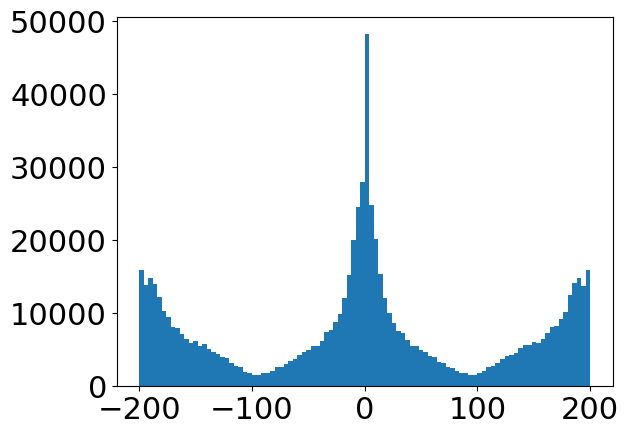

In [10]:
plt.hist(data['similarity_to_previous'], bins=100)

100%|██████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 8121.39it/s]


(-0.45, -0.05)

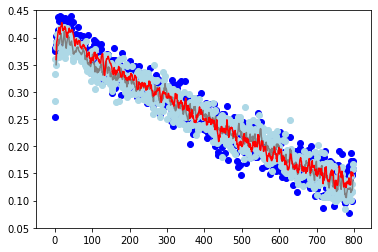

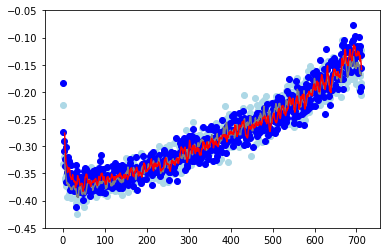

In [27]:
from tqdm import tqdm

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

#Based on similarity_to_previous
data_similar_ones = data[(data['similarity_to_previous']<100) & (data['similarity_to_previous']>-100)]
data_dissimilar_ones = data[~((data['similarity_to_previous']<100) & (data['similarity_to_previous']>-100))]

data_similar_ones = data_similar_ones.sort_values(by=["RT"])
data_dissimilar_ones = data_dissimilar_ones.sort_values(by=["RT"])

plt.figure()
similar_ones_biases_1back = []
for i in tqdm(range(len(data_similar_ones["RT"])//500)):
    similar_ones_biases_1back.append(data_similar_ones["1back_accuracy"][500*i:500*(i+1)].mean() - 0.5)
plt.scatter(range(len(data_similar_ones["RT"])//500), similar_ones_biases_1back, color='#0000FF')

dissimilar_ones_biases_1back = []
for i in tqdm(range(len(data_dissimilar_ones["RT"])//500)):
    dissimilar_ones_biases_1back.append(data_dissimilar_ones["1back_accuracy"][500*i:500*(i+1)].mean() - 0.5)
    

#Based on similarity_to_forward
similarity_1forward = data['malignancy'].shift(periods = -1) - data['malignancy'] #previous - current malignancy 
data['similarity_to_forward'] = similarity_1forward

data_similar_ones = data[(data['similarity_to_forward']<100) & (data['similarity_to_forward']>-100)]
data_dissimilar_ones = data[~((data['similarity_to_forward']<100) & (data['similarity_to_forward']>-100))]

data_similar_ones = data_similar_ones.sort_values(by=["RT"])
data_dissimilar_ones = data_dissimilar_ones.sort_values(by=["RT"])

similar_ones_biases_1forward = []
for i in tqdm(range(len(data_similar_ones["RT"])//500)):
    similar_ones_biases_1forward.append(data_similar_ones["1forward_accuracy"][500*i:500*(i+1)].mean() - 0.5)
plt.scatter(range(len(data_similar_ones["RT"])//500), similar_ones_biases_1forward, color='#ADD8E6')

dissimilar_ones_biases_1forward = []
for i in tqdm(range(len(data_dissimilar_ones["RT"])//500)):
    dissimilar_ones_biases_1forward.append(data_dissimilar_ones["1forward_accuracy"][500*i:500*(i+1)].mean() - 0.5)
    
#running mean calculation
similar_ones_biases_1forward_rm = running_mean(similar_ones_biases_1forward, 5)
similar_ones_biases_1back_rm = running_mean(similar_ones_biases_1back, 5)
plt.plot([x + 4 for x in range(len(data_similar_ones["RT"])//500 - 4)], similar_ones_biases_1forward_rm, '-', color='#808080')
plt.plot([x + 4 for x in range(len(data_similar_ones["RT"])//500 - 4)], similar_ones_biases_1back_rm, 'r-')

plt.ylim([0.05,0.45])


plt.figure()
plt.scatter(range(len(data_dissimilar_ones["RT"])//500), dissimilar_ones_biases_1forward, color='#ADD8E6')
plt.scatter(range(len(data_dissimilar_ones["RT"])//500), dissimilar_ones_biases_1back, color='#0000FF')

dissimilar_ones_biases_1forward_rm = running_mean(dissimilar_ones_biases_1forward, 5)
dissimilar_ones_biases_1back_rm = running_mean(dissimilar_ones_biases_1back, 5)
plt.plot([x + 4 for x in range(len(data_dissimilar_ones["RT"])//500 - 4)], dissimilar_ones_biases_1forward_rm, '-', color='#808080')
plt.plot([x + 4 for x in range(len(data_dissimilar_ones["RT"])//500 - 4)], dissimilar_ones_biases_1back_rm, 'r-')

plt.ylim([-0.45,-0.05])

100%|████████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 3877.09it/s]


(-0.2, 0.2)

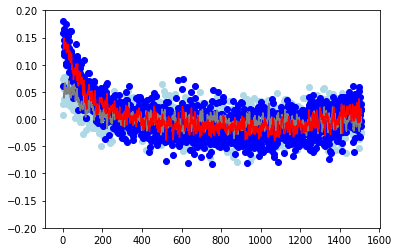

In [28]:
data_RT_ordered = data.sort_values(by=["RT"])
all_biases_1forward = []
all_biases_1back = []
for i in tqdm(range(len(data_RT_ordered["RT"])//500)):
    all_biases_1forward.append(data_RT_ordered["1forward_accuracy"][500*i:500*(i+1)].mean() - 0.5)
    all_biases_1back.append(data_RT_ordered["1back_accuracy"][500*i:500*(i+1)].mean() - 0.5)
plt.scatter(range(len(data_RT_ordered["RT"])//500), all_biases_1forward, color='#ADD8E6')
plt.scatter(range(len(data_RT_ordered["RT"])//500), all_biases_1back, color='#0000FF')

all_biases_1forward_rm = running_mean(all_biases_1forward, 5)
all_biases_1back_rm = running_mean(all_biases_1back, 5)
plt.plot([x + 4 for x in range(len(data_RT_ordered["RT"])//500 - 4)], all_biases_1forward_rm, '-', color='#808080')
plt.plot([x + 4 for x in range(len(data_RT_ordered["RT"])//500 - 4)], all_biases_1back_rm, 'r-')

plt.ylim([-0.2,0.2])

100%|████████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 3828.39it/s]


(-0.2, 0.2)

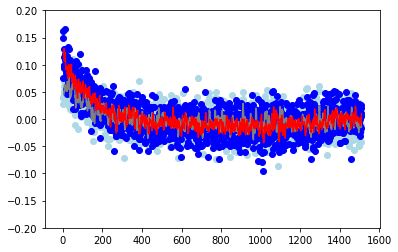

In [29]:
def get_forward(dataframe, id_col, correct_col, chosen_col, n_back):    
    df = dataframe
    is_valid = df[id_col].value_counts(sort=False)>n_back
    result = np.array([]) # create empty list
    for i, subject in enumerate(np.unique(df[id_col])): # loop over subjects
        if is_valid.values[i] == True:
            true_false_list = np.empty(np.abs(n_back)) # initialize with nan for first n_back trials
            true_false_list[:] = np.nan # select rows of currect subject
            df_subj = df.loc[df[id_col]==subject,]
            choices_subj = df_subj[chosen_col] 
            correct_subj = df_subj[correct_col] 
            tmp_list = np.array(choices_subj == correct_subj.shift(periods = n_back)) # calculate accuracy (True if choice[t] == correct[t-n_back], else False)
            true_false_list = np.append(tmp_list[:n_back], true_false_list) # append to inialized list
            result = np.append(result, true_false_list)
            
        elif is_valid.values[i] == False:
            num_rows = df[id_col][df[id_col]==subject].value_counts()
            true_false_list = np.empty([num_rows.values[0]]) # initialize with nan for rows with invalid data
            true_false_list[:] = np.nan
            result = np.append(result, true_false_list)

    return(result)

data['2forward_accuracy'] = get_forward(n_back = -2, dataframe = data, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')

data_RT_ordered = data.sort_values(by=["RT"])
all_biases_2forward = []
all_biases_2back = []
for i in tqdm(range(len(data_RT_ordered["RT"])//500)):
    all_biases_2forward.append(data_RT_ordered["2forward_accuracy"][500*i:500*(i+1)].mean() - 0.5)
    all_biases_2back.append(data_RT_ordered["2back_accuracy"][500*i:500*(i+1)].mean() - 0.5)
plt.scatter(range(len(data_RT_ordered["RT"])//500), all_biases_2forward, color='#ADD8E6')
plt.scatter(range(len(data_RT_ordered["RT"])//500), all_biases_2back, color='#0000FF')

all_biases_2forward_rm = running_mean(all_biases_2forward, 5)
all_biases_2back_rm = running_mean(all_biases_2back, 5)
plt.plot([x + 4 for x in range(len(data_RT_ordered["RT"])//500 - 4)], all_biases_2forward_rm, '-', color='#808080')
plt.plot([x + 4 for x in range(len(data_RT_ordered["RT"])//500 - 4)], all_biases_2back_rm, 'r-')

plt.ylim([-0.2,0.2])

(-0.2, 0.2)

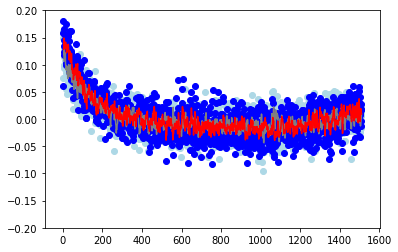

In [30]:
plt.scatter(range(len(data_RT_ordered["RT"])//500), all_biases_2back, color='#ADD8E6')
plt.scatter(range(len(data_RT_ordered["RT"])//500), all_biases_1back, color='#0000FF')

plt.plot([x + 4 for x in range(len(data_RT_ordered["RT"])//500 - 4)], all_biases_2back_rm, '-', color='#808080')
plt.plot([x + 4 for x in range(len(data_RT_ordered["RT"])//500 - 4)], all_biases_1back_rm, 'r-')

plt.ylim([-0.2,0.2])

#### RT Permutation Analysis

100%|██████████████████████████████████████| 707/707 [00:00<00:00, 29234.22it/s]


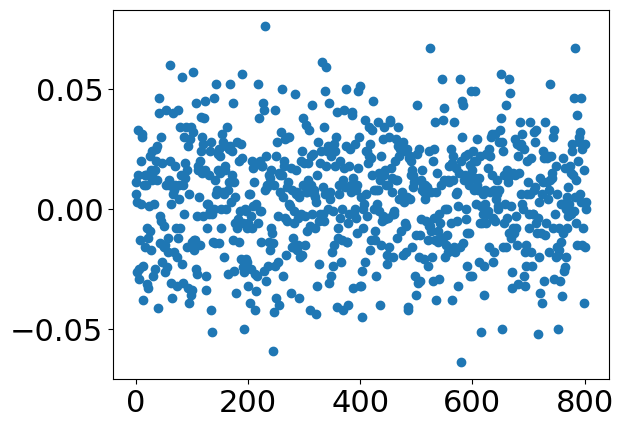

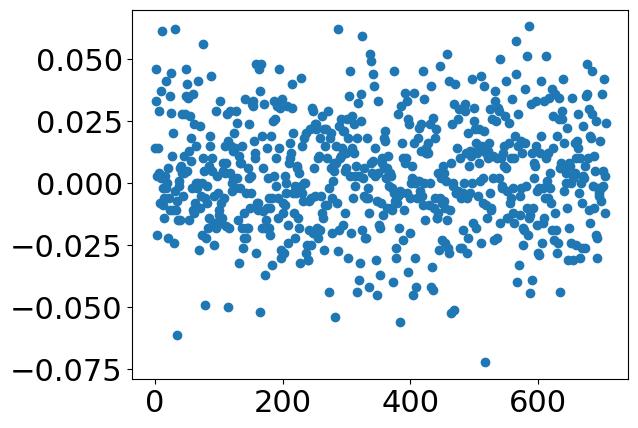

In [25]:
def get_backward(dataframe, id_col, correct_col, chosen_col, n_back):    
    df = dataframe
    is_valid = df[id_col].value_counts(sort=False)>n_back
    result = np.array([]) # create empty list
    for i, subject in enumerate(np.unique(df[id_col])): # loop over subjects
        if is_valid.values[i] == True:
            true_false_list = np.empty([n_back]) # initialize with nan for first n_back trials
            true_false_list[:] = np.nan # select rows of currect subject
            df_subj = df.loc[df[id_col]==subject,]
            choices_subj = df_subj[chosen_col] 
            correct_subj = df_subj[correct_col] 
            tmp_list = np.array(choices_subj == correct_subj.shift(periods = n_back)) # calculate accuracy (True if choice[t] == correct[t-n_back], else False)
            true_false_list = np.append(true_false_list, tmp_list[n_back:]) # append to inialized list
            result = np.append(result, true_false_list)
            
        elif is_valid.values[i] == False:
            num_rows = df[id_col][df[id_col]==subject].value_counts()
            true_false_list = np.empty([num_rows.values[0]]) # initialize with nan for rows with invalid data
            true_false_list[:] = np.nan
            result = np.append(result, true_false_list)

    return(result)

data_shuffled = data.copy()
# data_shuffled['chosen_answer'] = np.random.permutation(data_shuffled['chosen_answer'].values)
data_shuffled = data_shuffled.sample(frac=1).reset_index(drop=True)

## Recompute 1back_accuracy
data_shuffled['1back_accuracy'] = get_backward(n_back = 1, dataframe = data_shuffled, id_col = 'user_id', correct_col = 'current_correct_answer', chosen_col = 'chosen_answer')

## Recompute similarity
similarity_shuffled = data_shuffled['malignancy'].shift(periods = 1) - data_shuffled['malignancy'] #previous - current malignancy 
data_shuffled['similarity_to_previous'] = similarity_shuffled

data_similar_ones = data_shuffled[(data_shuffled['similarity_to_previous']<100) & (data_shuffled['similarity_to_previous']>-100)]
data_dissimilar_ones = data_shuffled[~((data_shuffled['similarity_to_previous']<100) & (data_shuffled['similarity_to_previous']>-100))]

data_similar_ones = data_similar_ones.sort_values(by=["RT"])
data_dissimilar_ones = data_dissimilar_ones.sort_values(by=["RT"])

plt.figure()
similar_ones_biases = []
for i in tqdm(range(len(data_similar_ones["RT"])//500)):
    similar_ones_biases.append(data_similar_ones["1back_accuracy"][500*i:500*(i+1)].mean() - 0.5)
plt.scatter(range(len(data_similar_ones["RT"])//500), similar_ones_biases)

plt.figure()
dissimilar_ones_biases = []
for i in tqdm(range(len(data_dissimilar_ones["RT"])//500)):
    dissimilar_ones_biases.append(data_dissimilar_ones["1back_accuracy"][500*i:500*(i+1)].mean() - 0.5)
plt.scatter(range(len(data_dissimilar_ones["RT"])//500), dissimilar_ones_biases)

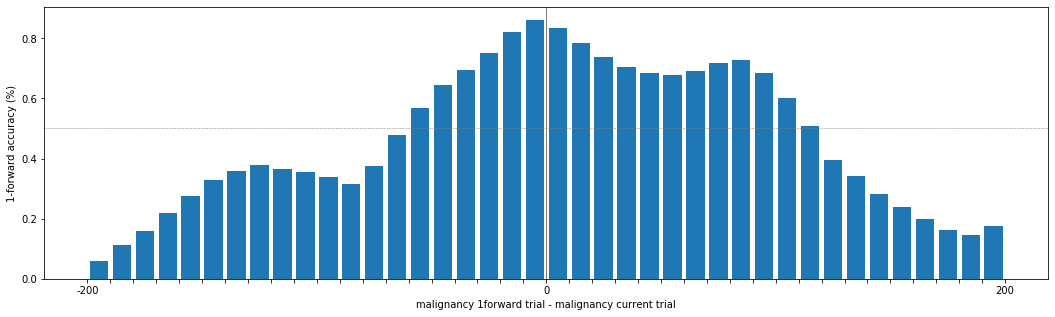

41


In [64]:
similarity_1forward = data['malignancy'].shift(periods = -1) - data['malignancy'] #previous - current malignancy 
data['similarity_to_1forward'] = similarity_1forward
data['similarity_1forward_bins'] = pd.cut(x=similarity_1forward, bins=np.arange(-200,210,10))
data_1forward_per_bin = data.groupby(['similarity_1forward_bins']).mean()

y = data_1forward_per_bin['1forward_accuracy']
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('1-forward accuracy (%)')
plt.xlabel('malignancy 1forward trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--') #

plt.show()
print(len(x_labels))

### 1-Forward analysis before Mergeing two sides

<Figure size 432x288 with 0 Axes>

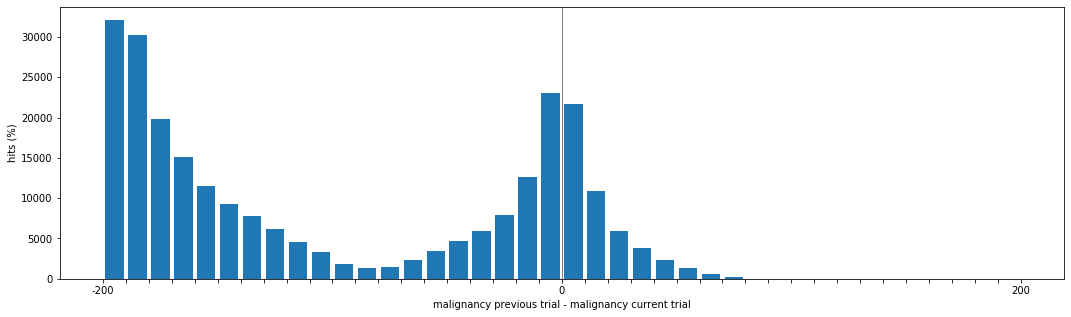

<Figure size 432x288 with 0 Axes>

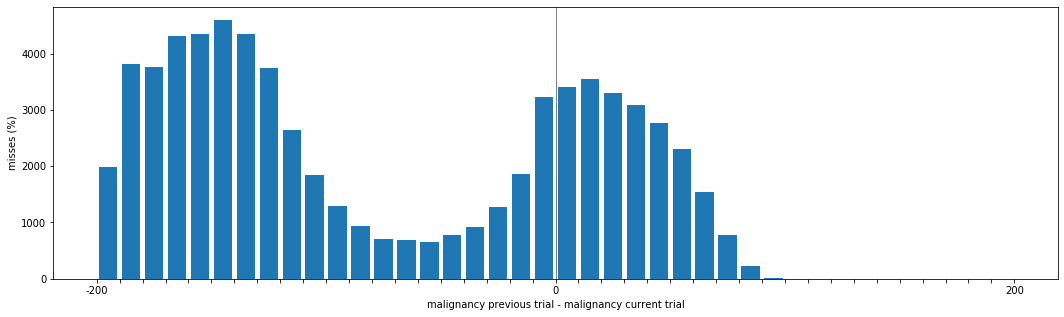

<Figure size 432x288 with 0 Axes>

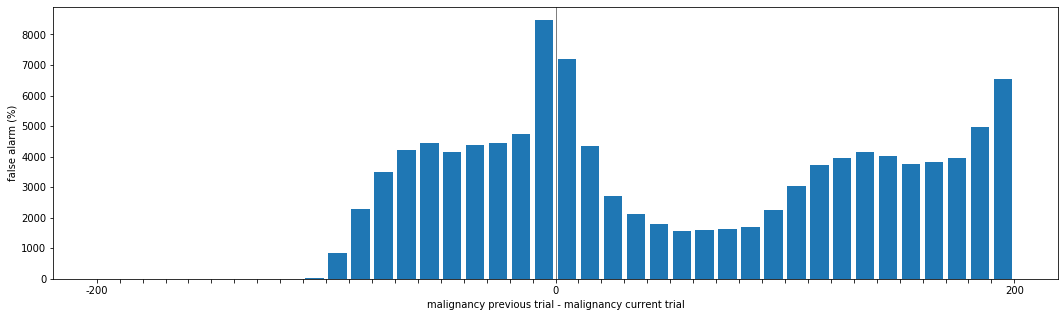

<Figure size 432x288 with 0 Axes>

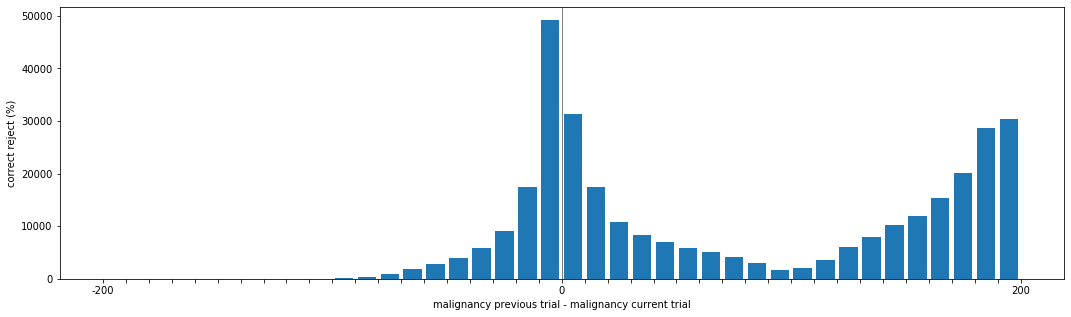

<Figure size 432x288 with 0 Axes>

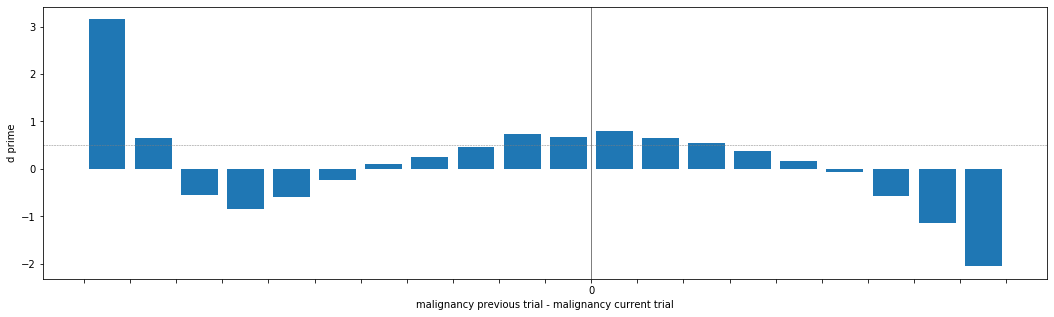

<Figure size 432x288 with 0 Axes>

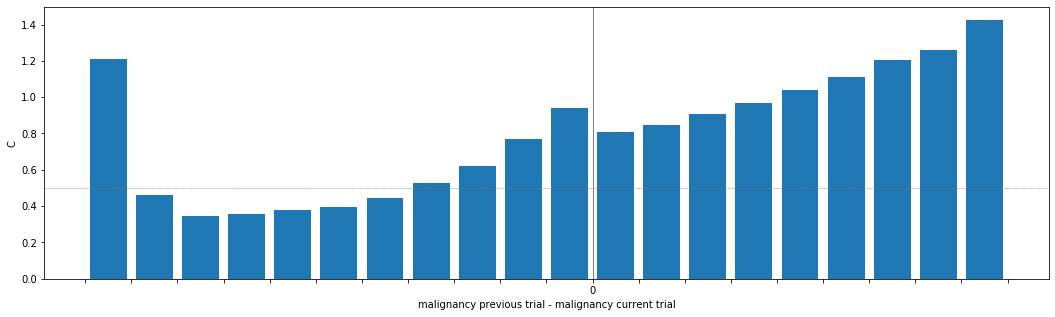

In [81]:
hit_1forward = []
miss_1forward = []
FA_1forward = []
CR_1forward = []
lengths_1forward = []

num_benign_1forward = []
num_malignant_1forward = []
for start in np.arange(-200,210,10):
    data_temp = data[data['similarity_1forward_bins'] == pd.Interval(start, start + 10, closed='right')]
    lengths_1forward.append(data_temp.shape[0])
#     hit_1forward.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum() / lenth)
#     FA_1forward.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum() / lenth)
#     miss_1forward.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum() / lenth)
#     CR_1forward.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['nevus']")).sum() / lenth)
    hit_1forward.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum())
    FA_1forward.append(((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum())
    miss_1forward.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum())
    CR_1forward.append(((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['nevus']")).sum())
    
    num_benign_1forward.append(FA_1forward[-1] + CR_1forward[-1])
    num_malignant_1forward.append(hit_1forward[-1] + miss_1forward[-1])

# PLOT 1: hits
plt.figure()
y = hit_1forward[:-1]
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: miss
plt.figure()
y = miss_1forward[:-1]
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 3: false alarm
plt.figure()
y = FA_1forward[:-1]
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 4: correct reject
plt.figure()
y = CR_1forward[:-1]
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 5: d'
plt.figure()
y_1forward_d = [stats.norm.ppf(a/c) - stats.norm.ppf(b/c) for (a,b,c) in zip(hit_1forward[:-1], FA_1forward[:-1], lengths_1forward[:-1])]
# y_1forward_d = [0 if a != a else a for a in y_1forward_d]
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1forward_d)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y_1forward_c = [-(stats.norm.ppf(a/c) + stats.norm.ppf(b/c))/2 for (a,b,c) in zip(hit_1forward[:-1], FA_1forward[:-1], lengths_1forward[:-1])]
# y_1forward_c = [0 if a != a else a for a in y_1forward_c]
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1forward_c)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

### 1-Forward analysis after Mergeing two sides

/Users/peterren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/peterren/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

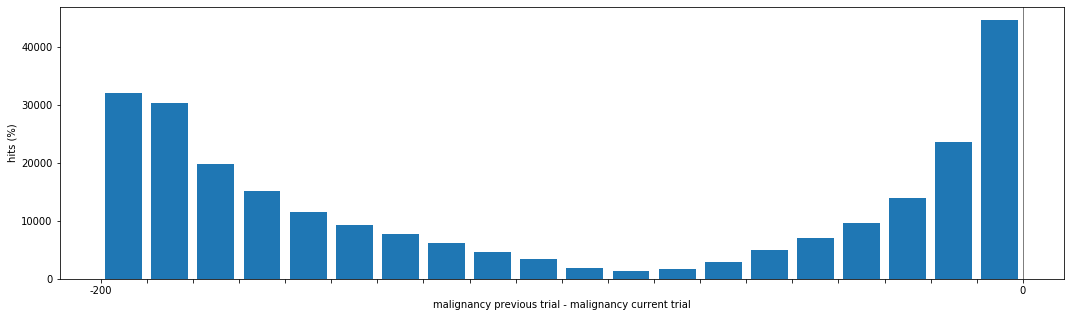

<Figure size 432x288 with 0 Axes>

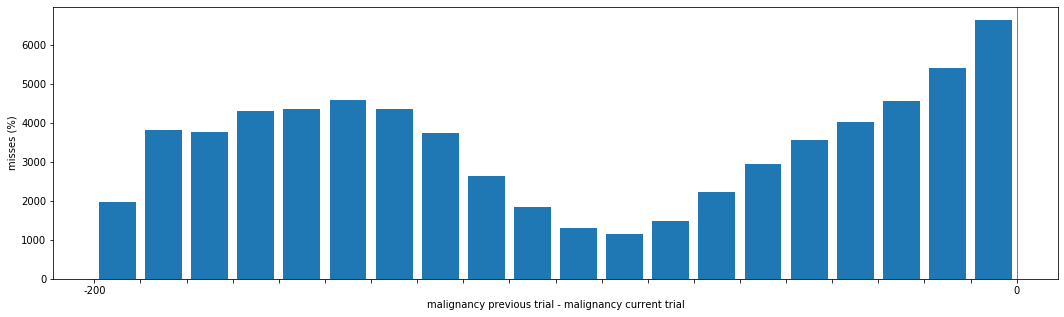

<Figure size 432x288 with 0 Axes>

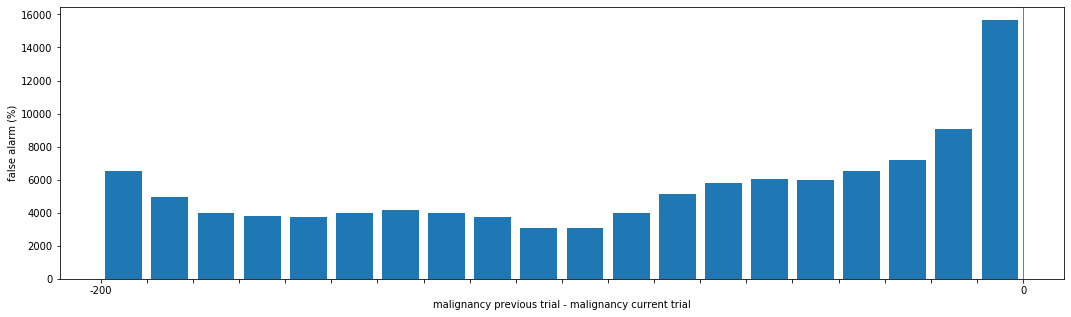

<Figure size 432x288 with 0 Axes>

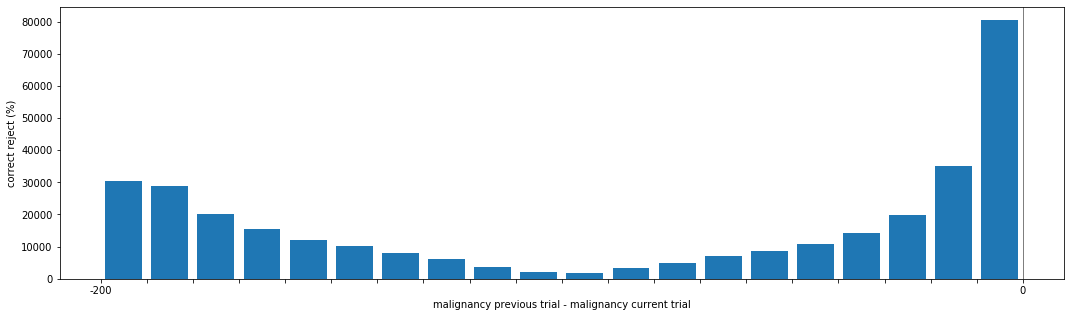

<Figure size 432x288 with 0 Axes>

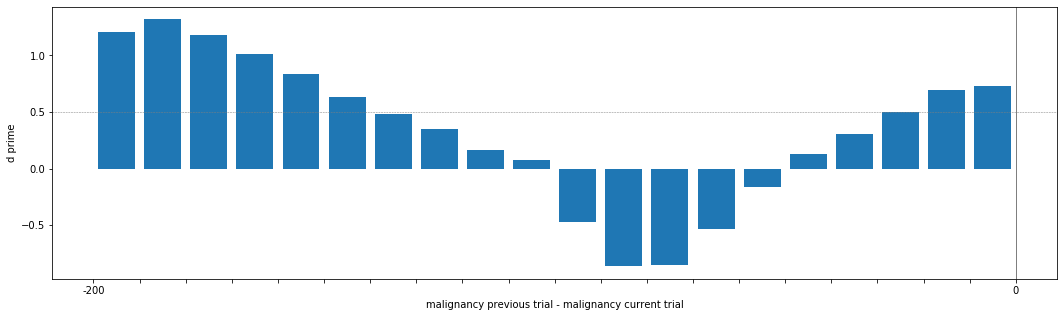

<Figure size 432x288 with 0 Axes>

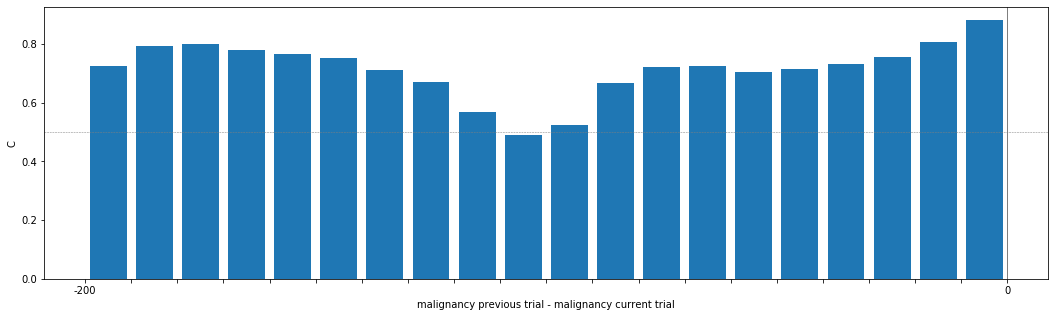

<Figure size 432x288 with 0 Axes>

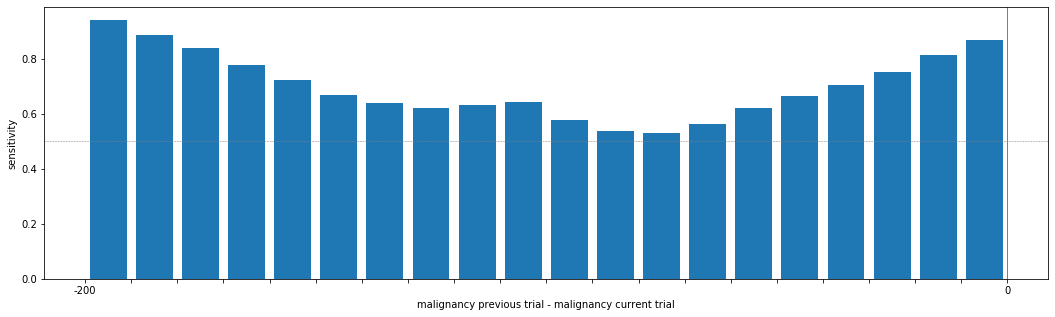

<Figure size 432x288 with 0 Axes>

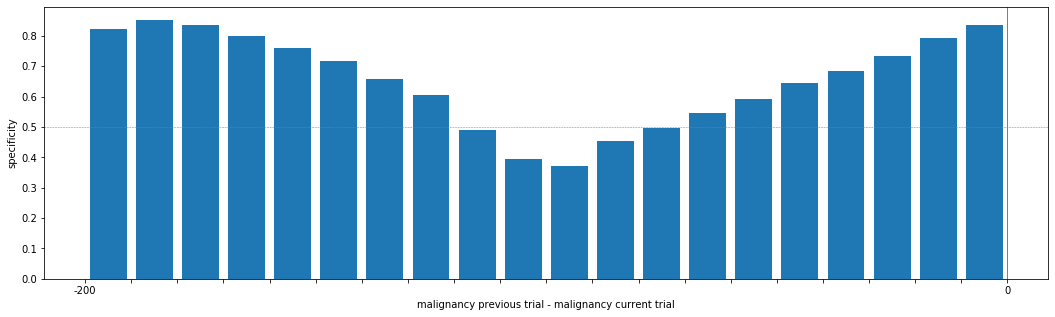

<Figure size 432x288 with 0 Axes>

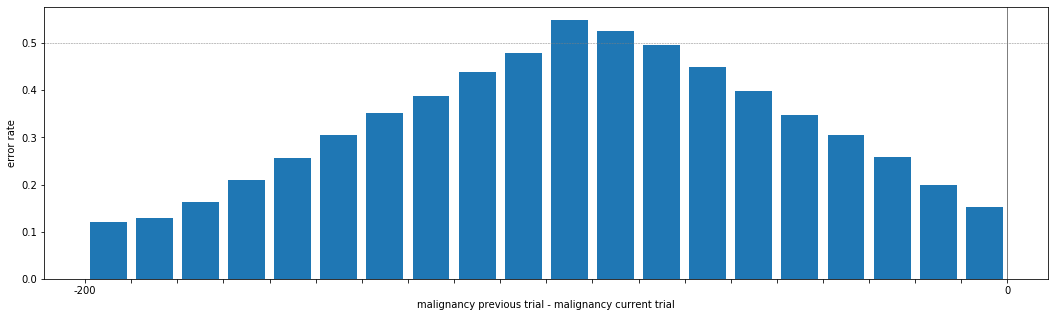

<Figure size 432x288 with 0 Axes>

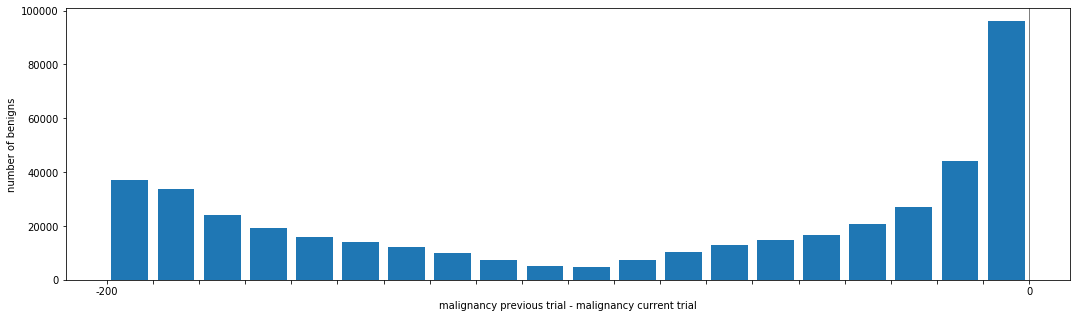

<Figure size 432x288 with 0 Axes>

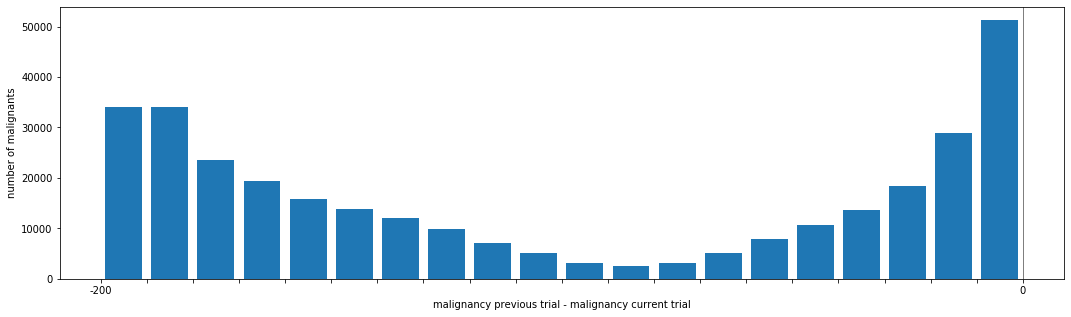

In [82]:
hit_1forward_merge = np.zeros(20,)
miss_1forward_merge = np.zeros(20,)
FA_1forward_merge = np.zeros(20,)
CR_1forward_merge = np.zeros(20,)
lengths_1forward_merge = np.zeros(20,)
num_benign_1forward_merge = np.zeros(20,)
num_malignant_1forward_merge = np.zeros(20,)
sensitivity_1forward_merge = np.zeros(20,)
specificity_1forward_merge = np.zeros(20,)
error_rate_1forward_merge = np.zeros(20,)

for i in range(20):
    hit_1forward_merge[i] = hit_1forward[i] + hit_1forward[39 - i]
    miss_1forward_merge[i] = miss_1forward[i] + miss_1forward[39 - i]
    FA_1forward_merge[i] = FA_1forward[i] + FA_1forward[39 - i]
    CR_1forward_merge[i] = CR_1forward[i] + CR_1forward[39 - i]
    lengths_1forward_merge[i] = lengths_1forward[i] + lengths_1forward[39 - i]
    num_benign_1forward_merge[i] = num_benign_1forward[i] + num_benign_1forward[39 - i]
    num_malignant_1forward_merge[i] = num_malignant_1forward[i] + num_malignant_1forward[39 - i]
    
    sensitivity_1forward_merge[i] = hit_1forward_merge[i] / (hit_1forward_merge[i] + miss_1forward_merge[i])
    specificity_1forward_merge[i] = CR_1forward_merge[i] / (CR_1forward_merge[i] + FA_1forward_merge[i])
    error_rate_1forward_merge[i] = 1 - (hit_1forward_merge[i] + CR_1forward_merge[i]) / lengths_1forward_merge[i]

# PLOT 1: hits
plt.figure()
y = hit_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: miss
plt.figure()
y = miss_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 3: false alarm
plt.figure()
y = FA_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 4: correct reject
plt.figure()
y = CR_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 5: d'
plt.figure()
y_1forward_d = [stats.norm.ppf(a/c) - stats.norm.ppf(b/c) for (a,b,c) in zip(hit_1forward_merge, FA_1forward_merge, lengths_1forward_merge)]
# y_1back_d = [0 if a != a else a for a in y_1back_d]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1forward_d)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y_1forward_c = [-(stats.norm.ppf(a/c) + stats.norm.ppf(b/c))/2 for (a,b,c) in zip(hit_1forward_merge, FA_1forward_merge, lengths_1forward_merge)]
# y_1back_c = [0 if a != a else a for a in y_1back_c]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1forward_c)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 7: sensitivity
plt.figure()
y = sensitivity_1forward_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('sensitivity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 8: specificity
plt.figure()
y = specificity_1forward_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('specificity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 9: error rate
plt.figure()
y = error_rate_1forward_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('error rate')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 1: benign samples
plt.figure()
y = num_benign_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('number of benigns')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: malignant samples
plt.figure()
y = num_malignant_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('number of malignants')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

### Serial Dependence on 1-back accuracy before merging

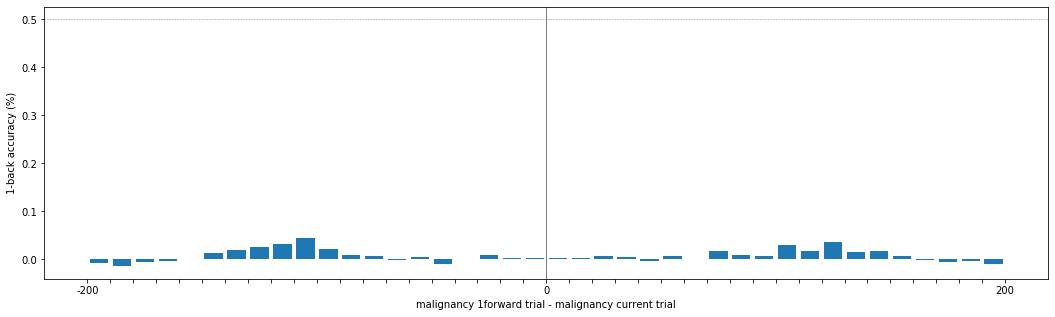

In [76]:
y = data_per_bin['1back_accuracy'] - data_1forward_per_bin['1forward_accuracy']
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('1-back accuracy (%)')
plt.xlabel('malignancy 1forward trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--') #

plt.show()

### Serial Dependence on 1-back accuracy after merging

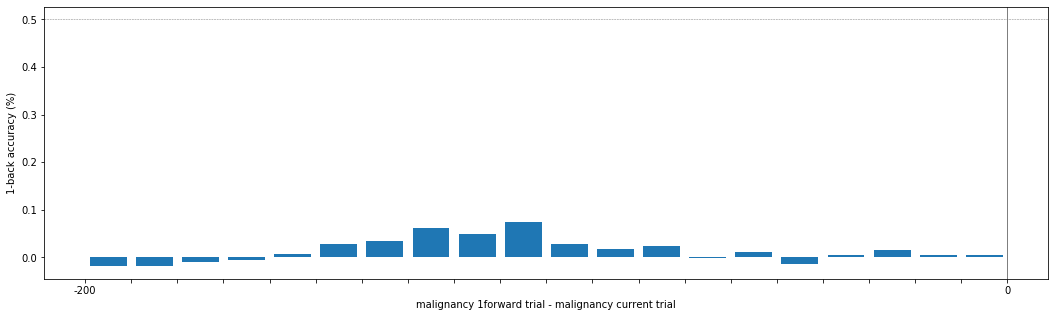

In [77]:
# y = data_per_bin['1back_accuracy'] - data_1forward_per_bin['1forward_accuracy']

y_merged = []
y = list(y)
for i in range(20):
    y_merged.append(y[i] + y[39 - i])
    
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_merged)
plt.ylabel('1-back accuracy (%)')
plt.xlabel('malignancy 1forward trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--') #

plt.show()

### Serial Dependence Analysis after merging

sum of hits:-2.38094923154863e-05
sum of miss:-1.7195744450073324e-05
sum of FA:1.3227495730826384e-06
sum of CR:-1.3227495730826384e-06
sum of sensitivity:-0.1941353479753229
sum of specificity:-0.11597408036683715
sum of error rate:0.14007261837354235


<Figure size 432x288 with 0 Axes>

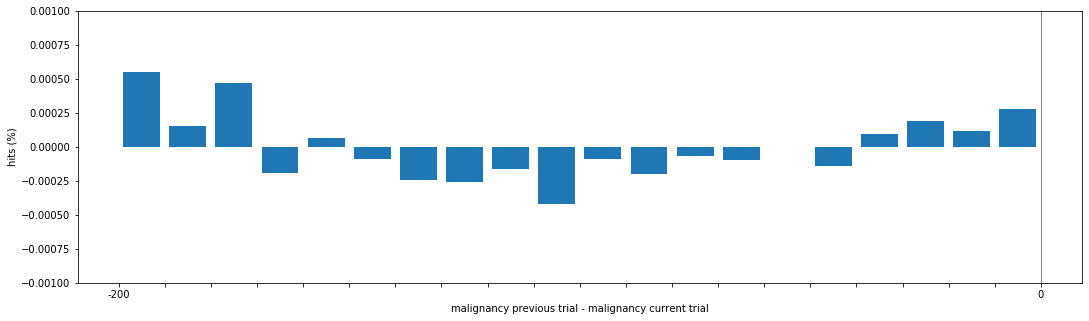

<Figure size 432x288 with 0 Axes>

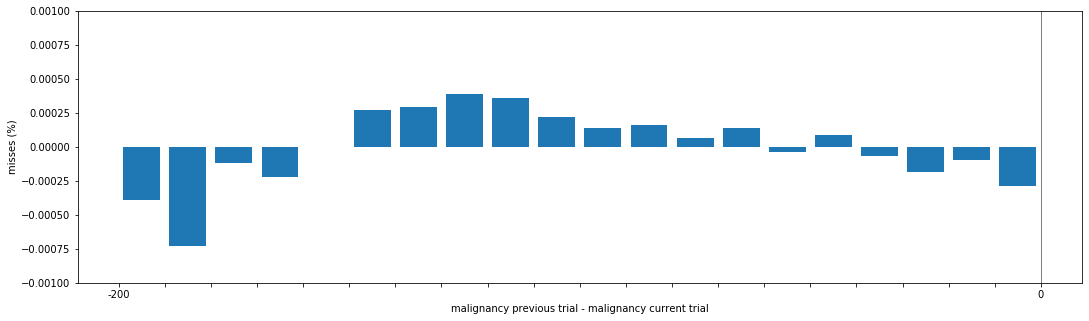

<Figure size 432x288 with 0 Axes>

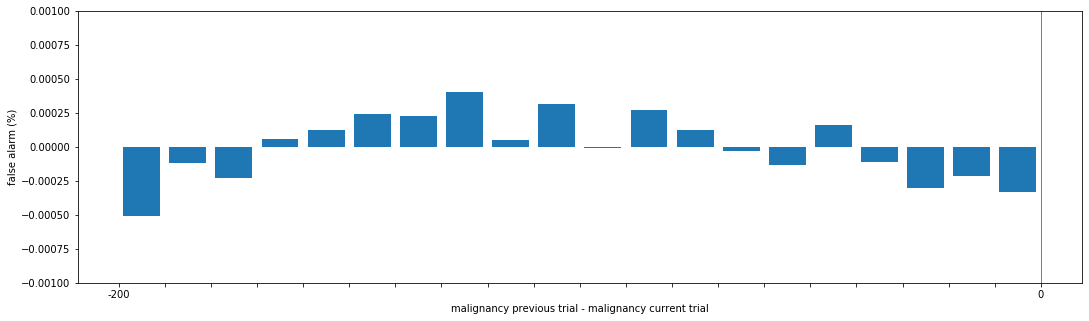

<Figure size 432x288 with 0 Axes>

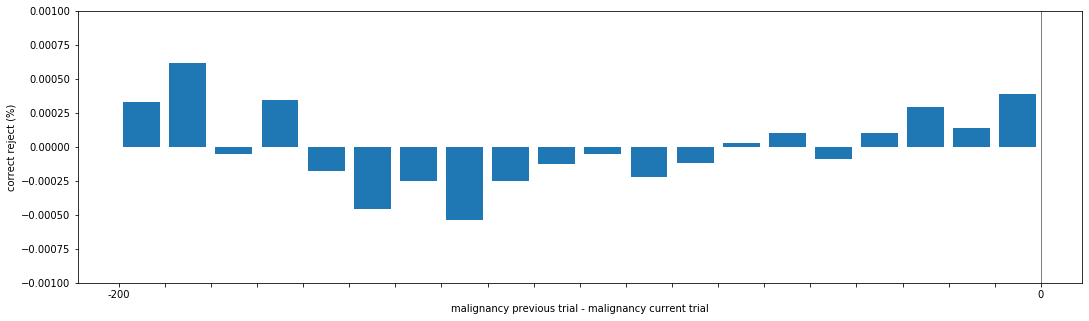

<Figure size 432x288 with 0 Axes>

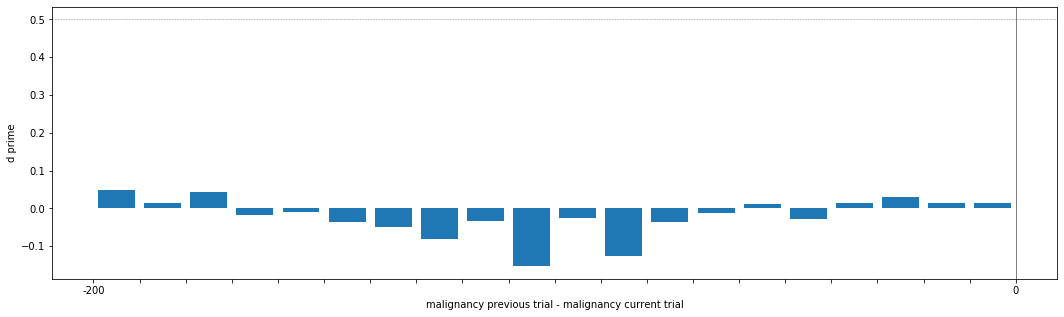

<Figure size 432x288 with 0 Axes>

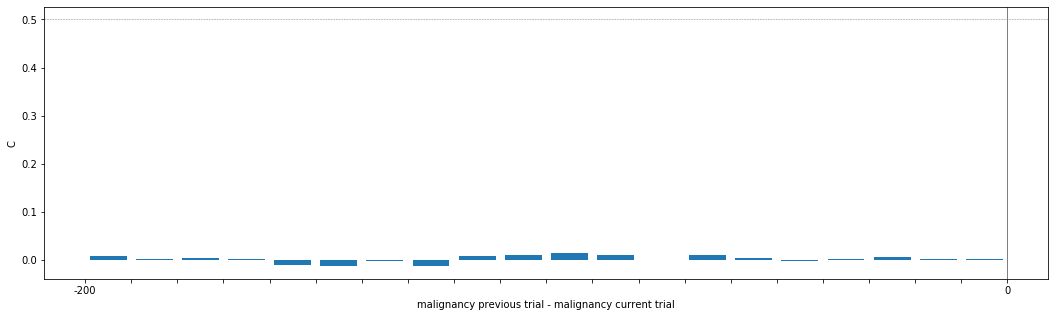

<Figure size 432x288 with 0 Axes>

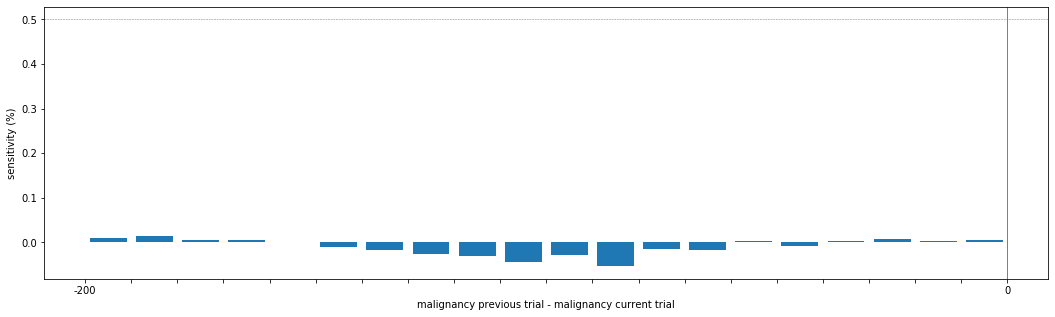

<Figure size 432x288 with 0 Axes>

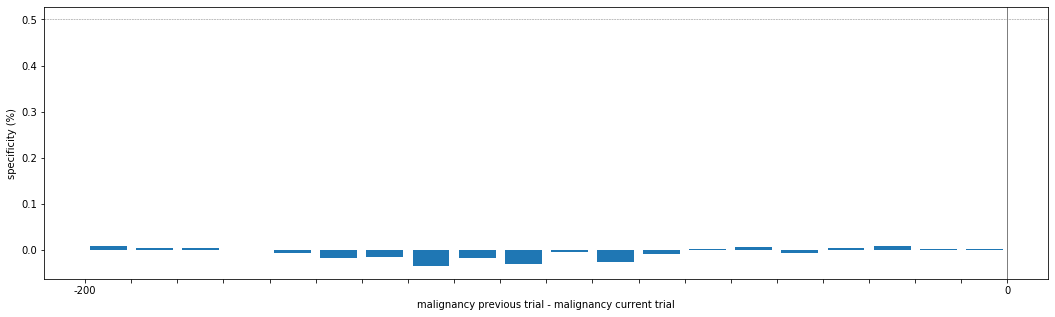

<Figure size 432x288 with 0 Axes>

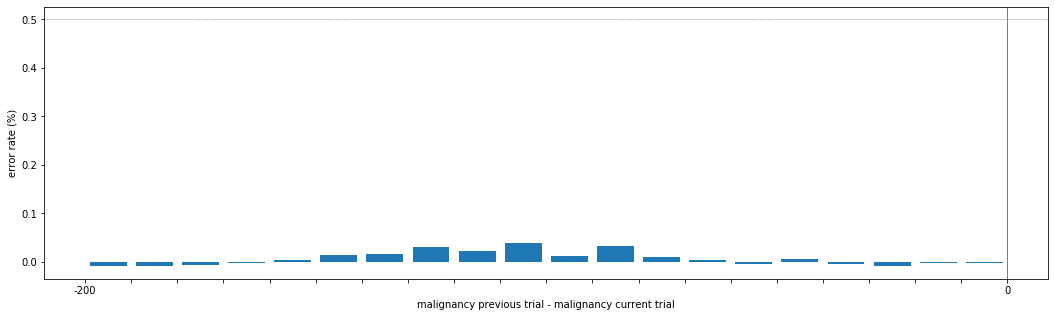

In [84]:
lenth = data.shape[0]
# PLOT 1: hits
plt.figure()
y = [(a - b) / lenth for (a,b) in zip(hit_1back_merge, hit_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
plt.ylim([-0.001, 0.001])
print('sum of hits:' + str(sum(y)))

# PLOT 2: miss
plt.figure()
y = [(a - b) / lenth for (a,b) in zip(miss_1back_merge, miss_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
plt.ylim([-0.001, 0.001])
print('sum of miss:' + str(sum(y)))

# PLOT 3: false alarm
plt.figure()
y = [(a - b) / lenth for (a,b) in zip(FA_1back_merge, FA_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
plt.ylim([-0.001, 0.001])
print('sum of FA:' + str(sum(y)))

# PLOT 4: correct reject
plt.figure()
y = [(a - b) / lenth for (a,b) in zip(CR_1back_merge, CR_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
plt.ylim([-0.001, 0.001])
print('sum of CR:' + str(sum(y)))

# PLOT 5: d'
plt.figure()
y = [a - b for (a,b) in zip(y_1back_d, y_1forward_d)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y = [a - b for (a,b) in zip(y_1back_c, y_1forward_c)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 7: sensitivity
plt.figure()
y = [a - b for (a,b) in zip(sensitivity_1back_merge, sensitivity_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('sensitivity (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
# plt.ylim([-0.001, 0.001])
print('sum of sensitivity:' + str(sum(y)))

# PLOT 8: specificity
plt.figure()
y = [a - b for (a,b) in zip(specificity_1back_merge, specificity_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('specificity (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
# plt.ylim([-0.001, 0.001])
print('sum of specificity:' + str(sum(y)))

# PLOT 9: error rate
plt.figure()
y = [a - b for (a,b) in zip(error_rate_1back_merge, error_rate_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('error rate (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')
# plt.ylim([-0.001, 0.001])
print('sum of error rate:' + str(sum(y)))

### Serial Dependence vs d'

[0.00076683 0.50325161]


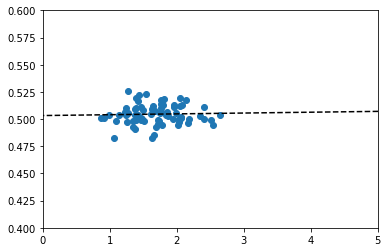

In [116]:
data_dropedna = data.dropna()

sample_size = 10000
N = len(data_dropedna) // sample_size

x_d = np.zeros(N,)
y_sd = np.zeros(N,)
for i in range(N):
    data_temp = data_dropedna[sample_size * i : sample_size * (i + 1)]
    hit_temp = ((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum()
    FA_temp = ((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum()
    x_d[i] = 1 / (stats.norm.ppf(hit_temp/sample_size) - stats.norm.ppf(FA_temp/sample_size))
    y_sd[i] = data_temp["1back_accuracy"].mean()

plt.scatter(x_d, y_sd)

coef = np.polyfit(x_d, y_sd, 1)
poly1d_fn = np.poly1d(coef)

x_0 = np.linspace(-5, 20, 100)
plt.plot(x_0, poly1d_fn(x_0),'--k')
plt.xlim(0,5)
plt.ylim(0.4,0.6)

print(coef)

In [70]:
data[(data['similarity_to_1forward']<50) & (data['similarity_to_1forward']>-50)]['1back_accuracy'].mean()

0.5071811748010496

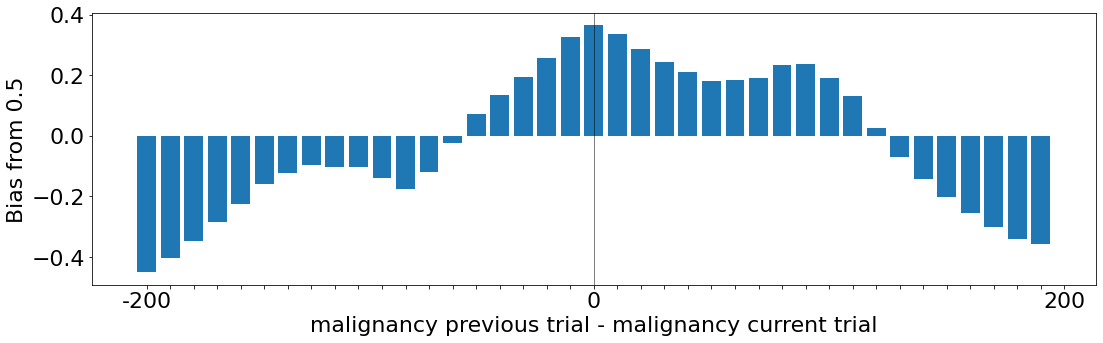

In [12]:
# PLOT 2: Similarity Barplot over all trials
y = data_per_bin['1back_accuracy']
y = y-0.5
x = data_per_bin.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Bias from 0.5')
plt.xlabel('malignancy previous trial - malignancy current trial')
#plt.title('Bias towards previous image for different levels of similarity')

plt.axvline(x=19,linewidth=0.5, color='black')

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: -0.5: Bias away from previous image, 0.5: Bias towards previous images 

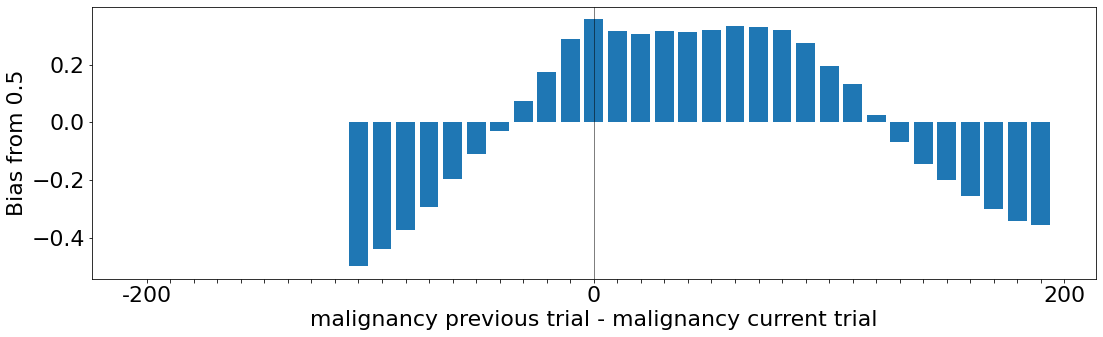

In [13]:
# PLOT 3: Similarity Barplot FOR NEVUS IN CURRENT TRIAL ONLY

nevus_only = data[data['current_correct_answer']== "['nevus']"]
data_per_bin_n = nevus_only.groupby(['similarity_bins']).mean()

y = data_per_bin_n['1back_accuracy']
y = y-0.5
y = y.fillna(0)
x = data_per_bin_n.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Bias from 0.5')
plt.xlabel('malignancy previous trial - malignancy current trial')
#plt.title('Bias towards previous image for different levels of similarity: Benign images in current trial only')

plt.axvline(x=19,linewidth=0.5, color='black')

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: -0.5: Bias away from previous image, 0.5: Bias towards previous images 

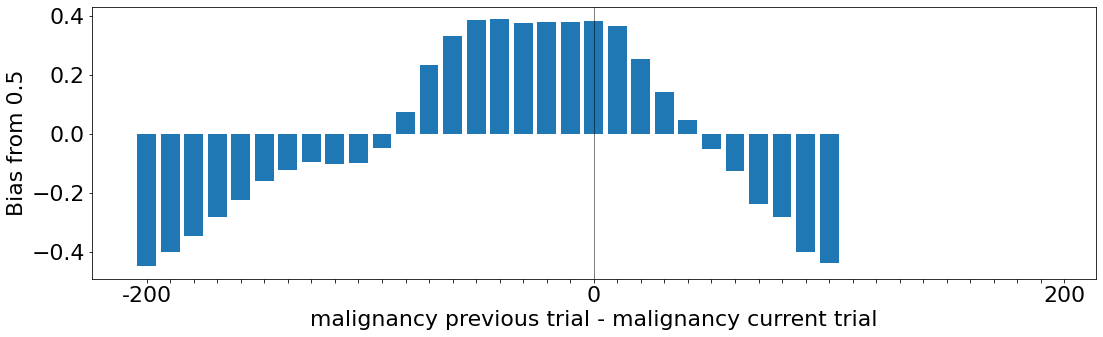

In [14]:
# PLOT 4: Similarity Barplot FOR MELANOMA IN CURRENT TRIAL ONLY

melanoma_only = data[data['current_correct_answer']== "['melanoma']"]
data_per_bin_m = melanoma_only.groupby(['similarity_bins']).mean()

y = data_per_bin_m['1back_accuracy']
y = y-0.5
y = y.fillna(0)
x = data_per_bin_m.index
y_pos = np.arange(len(x))
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[19] = 0
x_labels[39] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Bias from 0.5')
plt.xlabel('malignancy previous trial - malignancy current trial')
#plt.title('Bias towards previous image for different levels of similarity: Malignant images in current trial only')

plt.axvline(x=19,linewidth=0.5, color='black')

plt.show()

# x-axis: -200: Previous image was very benign, 200: Previous image was very malignant
# y-axis: -0.5: Bias away from previous image, 0.5: Bias towards previous images 

In [ ]:
data.to_csv('prepped_data.csv')